In [4]:
# !pip install yfinance

     |████████████████████████████████| 6.3 MB 5.5 MB/s 
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [382]:
import bs4 as bs
import requests
import yfinance as yf
import datetime
import pandas as pd
import numpy as np

resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
soup = bs.BeautifulSoup(resp.text, 'lxml')
table = soup.find('table', {'class': 'wikitable sortable'})
tickers = []
for row in table.findAll('tr')[1:21]:
    ticker = row.findAll('td')[0].text
    tickers.append(ticker)

tickers = [s.replace('\n', '') for s in tickers]
start = datetime.datetime(2009,9,1)
end = datetime.datetime(2021,9,17)
data = yf.download(tickers, start=start, end=end, interval='1mo')['Adj Close']
data = data.dropna()
sp500 = yf.download('^GSPC', start=start, end=end, interval='1mo')['Adj Close']
sp500 = sp500.dropna()
print(data)

[*********************100%***********************]  20 of 20 completed
[*********************100%***********************]  1 of 1 completed
                     A         AAP  ...        LNT         MMM
Date                                ...                       
2013-12-01   38.062290  107.439621  ...  20.004713  111.798286
2014-01-01   38.790314  111.510399  ...  20.144278  102.184845
2014-02-01   37.976494  123.699699  ...  21.239988  107.398125
2014-03-01   37.302750  122.864418  ...  22.246378  108.849976
2014-04-01   36.048653  117.860313  ...  22.900341  111.602135
...                ...         ...  ...        ...         ...
2021-05-01  137.777130  187.851089  ...  56.359623  198.415100
2021-06-01  147.432388  203.108505  ...  54.988842  195.533951
2021-07-01  152.838547  211.031631  ...  57.720531  194.854706
2021-08-01  175.251785  201.866302  ...  60.358994  191.704590
2021-09-01  157.334091  207.876999  ...  55.583096  174.003937

[94 rows x 20 columns]


In [383]:
data = data.sort_index()
for col in data.columns:
  data[col] = data[col]/data[col].shift()-1

sp500 = sp500.sort_index()
sp500 = pd.DataFrame(sp500)
sp500=sp500/sp500.shift()-1

In [384]:
# data = data[1:].T.transform(np.sort)
data = data[1:]
data = data.reset_index()

sp500 = sp500[1:]
sp500 = sp500.reset_index()
sp500

,Date,Adj Close
0,2009-10-01,-0.019762
1,2009-11-01,0.057364
2,2009-12-01,0.017771
3,2010-01-01,-0.036974
4,2010-02-01,0.028514
...,...,...
139,2021-05-01,0.005486
140,2021-06-01,0.022214
141,2021-07-01,0.022748
142,2021-08-01,0.028990


In [385]:
df = data.copy()
spx = sp500.copy()

df['quarter'] = df['Date'].dt.to_period('Q')
df = df.drop_duplicates(subset='quarter', keep="last")
df = df.set_index('Date')
df = df.drop(['quarter'],axis=1)
df = df.T



spx['quarter'] = spx['Date'].dt.to_period('Q')
spx = spx.drop_duplicates(subset='quarter', keep="last")
spx = spx.set_index('Date')
spx = spx.drop(['quarter'],axis=1)
spx = spx[17:]

check_spx = spx.copy()
spx = np.array(spx)

In [386]:
deposit = 10000
amount = deposit
res_1 = []
res_2 = []

for col in df.columns:
  df[col] = df[col].sort_values(ascending=False).head(10)
  df = pd.DataFrame(df)
  df['prof'] = (df[col]+1)*(amount/10)
  revenue = df['prof'].sum()
  income = revenue/amount - 1
  amount = revenue
  res_1.append(income)
  res_2.append(revenue)

In [387]:
sp_res_1 = []
sp_res_2 = []
am = deposit

for sp in spx:
  rev = float((sp+1)*am)
  inc = float(rev/am - 1)
  am = rev
  sp_res_1.append(rev)
  sp_res_2.append(inc)

In [388]:
a = 1
res_3 = []
for row in res_1:
    cr = (row+1)*a
    a = row+1
    res_3.append(cr-1)

x=((res_2[-1]/10000)**(1/7))-1

In [389]:
b = 1
sp_res_3 = []

for row in sp_res_2:
  cr = (row+1)*b
  b = row + 1
  sp_res_3.append(cr-1)

y = ((sp_res_1[-1]/10000)**(1/7))-1

In [390]:
all_data = check_spx
all_data['sp500'] = sp_res_3
all_data['stocks'] = res_3
all_data = all_data[['sp500','stocks']]

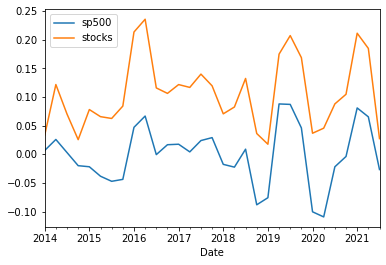

In [332]:
all_data.plot()

In [391]:
vol_st = np.std(all_data['sp500'])
vol_sp = np.std(all_data['stocks'])
table = pd.DataFrame({'Тип':['stocks','sp500'],
                      'Абсолютная_доходность':[res_2[-1]-deposit, sp_res_1[-1]-deposit],
                      'Доходность_за_весь_в_период_в_годовых %':[x*100,y*100],
                      'Волатильность':[vol_st,vol_sp]})
table

,Тип,Абсолютная_доходность,Доходность_за_весь_в_период_в_годовых %,Волатильность
0,stocks,35984.152917,24.353586,0.051338
1,sp500,-500.589129,-0.730963,0.060771
